![NeuronUnit Logo](https://raw.githubusercontent.com/scidash/assets/master/logos/neuronunit-logo-text.png)
# Chapter 3
Back to [Chapter 2](chapter2.ipynb)

Here we'll link these tests into a suite and use suite hooks to make the parameters of the second test depend on the outcome of the first.  We'll also add a lot of other tests to the suite, and show how we can parameterically vary the model and see how its performance on the suite changes.

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
import quantities as pq
import sciunit
import neuronunit
from neuronunit import aibs
from neuronunit.models.reduced import ReducedModel

In [2]:
import quantities as pq
from neuronunit import tests as nu_tests, neuroelectro
neuron = {'nlex_id': 'nifext_50'} # Layer V pyramidal cell
tests = []

dataset_id = 354190013  # Internal ID that AIBS uses for a particular Scnn1a-Tg2-Cre 
                        # Primary visual area, layer 5 neuron.
    
# Obtain the empirical rheobase current from the Allen Brain Insitute Cell Types database.  
observation = aibs.get_observation(dataset_id, 'rheobase')
rheobase_test = nu_tests.RheobaseTest(observation=observation)
tests += [rheobase_test]
    
test_class_params = [(nu_tests.InputResistanceTest, {}),
                     (nu_tests.TimeConstantTest, {}),
                     (nu_tests.CapacitanceTest, {}),
                     (nu_tests.RestingPotentialTest, {}),
                     (nu_tests.InjectedCurrentAPWidthTest, {}),
                     (nu_tests.InjectedCurrentAPAmplitudeTest, {}),
                     (nu_tests.InjectedCurrentAPThresholdTest, {})
                    ]

# Obtain all other parameters from neuroelectro.org.
for cls, params in test_class_params:
    observation = cls.neuroelectro_summary_observation(neuron)
    tests += [cls(observation, **params)]
    
# A hook to update all tests after the RheobaseTest to use the rheobase current (to produce exactly one AP)
def update_amplitude(test,tests,score):
    rheobase = score.prediction['value']
    for test in tests[1:]:
        if 'Injected' in test.name:
            # Set current injection to just suprathreshold
            test.params['injected_square_current']['amplitude'] = rheobase*1.01 
    
hooks = {tests[0]: {'f': update_amplitude}}
suite = sciunit.TestSuite(tests,name="vm_suite", hooks=hooks)

Getting Rheobase cached data value for from AIBS dataset 354190013
Getting Input Resistance data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Input+Resistance
Getting Membrane Time Constant data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Membrane+Time+Constant
Getting Cell Capacitance data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Cell+Capacitance
Getting Resting membrane potential data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Resting+membrane+potential
Getting Spike Half-Width data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Spike+Half-Width
Getting Spike Amplitude data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Spike+Amplitude
Getting Spike Threshold data values from neuroelectro.org
http://neuroelectro.org/api/1/nes/?nlex=n

### The Izhikevich model here is defined in an NeuroML2/LEMS file.  
### We will run it using the jNeuroML backend for simplicity, although this is *much* slower than the native NEURON backend.  

In [3]:
# This example is from https://github.com/OpenSourceBrain/IzhikevichModel.
from pathlib import Path
LEMS_MODEL_PATH = Path(neuronunit.__path__[0]).parent / 'docs' / 'data' / 'NeuroML2' / 'LEMS_2007One.xml'
model = ReducedModel(LEMS_MODEL_PATH, name='Vanilla_Model', backend='jNeuroML')

### Run a series of tests.  The RheobaseTest is run first to obtain the rheobase current to use in all the other tests.

In [4]:
score_matrix = suite.judge(model)

Score: Fail for Vanilla_Model on RheobaseTest
Score: Z = -0.53 for Vanilla_Model on InputResistanceTest
Score: Z = -0.94 for Vanilla_Model on TimeConstantTest
Score: Z = -0.28 for Vanilla_Model on CapacitanceTest
Score: Z = 1.26 for Vanilla_Model on RestingPotentialTest
{'duration': array(300.) * ms, 'delay': array(100.) * ms, 'amplitude': array(52.37402344) * pA}


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for Vanilla_Model on InjectedCurrentAPWidthTest


Spike train had length 0; no spike waveforms could be extracted.
Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for Vanilla_Model on InjectedCurrentAPAmplitudeTest


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for Vanilla_Model on InjectedCurrentAPThresholdTest


In [5]:
score_matrix.add_mean().T

,Vanilla_Model
Mean,nan
RheobaseTest,Fail
InputResistanceTest,Z = -0.53
TimeConstantTest,Z = -0.94
CapacitanceTest,Z = -0.28
RestingPotentialTest,Z = 1.26
InjectedCurrentAPWidthTest,Insufficient Data
InjectedCurrentAPAmplitudeTest,Insufficient Data
InjectedCurrentAPThresholdTest,Insufficient Data


### Now we can sweep across a parameter (the resting potential) and run the same test suite on a model corresponding to each value of this parameter.

In [6]:
models = []
for vr in np.linspace(-80, -50, 4):
    model = ReducedModel(LEMS_MODEL_PATH, 
                         name='V_rest=%dmV' % vr, 
                         attrs={'//izhikevich2007Cell':
                                    {'vr':'%d mV' % vr}
                               })
    models.append(model)
models

[V_rest=-80mV (ReducedModel),
 V_rest=-70mV (ReducedModel),
 V_rest=-60mV (ReducedModel),
 V_rest=-50mV (ReducedModel)]

In [7]:
score_matrix = suite.judge(models)

Score: Fail for V_rest=-80mV on RheobaseTest
Score: Z = -1.04 for V_rest=-80mV on InputResistanceTest
Score: Z = -1.56 for V_rest=-80mV on TimeConstantTest
Score: Z = -0.30 for V_rest=-80mV on CapacitanceTest
Score: Z = -1.80 for V_rest=-80mV on RestingPotentialTest
{'duration': array(300.) * ms, 'delay': array(100.) * ms, 'amplitude': array(244.56005859) * pA}


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-80mV on InjectedCurrentAPWidthTest


Spike train had length 0; no spike waveforms could be extracted.
Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-80mV on InjectedCurrentAPAmplitudeTest


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-80mV on InjectedCurrentAPThresholdTest
Score: Fail for V_rest=-70mV on RheobaseTest
Score: Z = -0.87 for V_rest=-70mV on InputResistanceTest
Score: Z = -1.35 for V_rest=-70mV on TimeConstantTest
Score: Z = -0.30 for V_rest=-70mV on CapacitanceTest
Score: Z = -0.27 for V_rest=-70mV on RestingPotentialTest
{'duration': array(300.) * ms, 'delay': array(100.) * ms, 'amplitude': array(130.93505859) * pA}


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-70mV on InjectedCurrentAPWidthTest


Spike train had length 0; no spike waveforms could be extracted.
Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-70mV on InjectedCurrentAPAmplitudeTest


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-70mV on InjectedCurrentAPThresholdTest
Score: Fail for V_rest=-60mV on RheobaseTest
Score: Z = -0.53 for V_rest=-60mV on InputResistanceTest
Score: Z = -0.94 for V_rest=-60mV on TimeConstantTest
Score: Z = -0.28 for V_rest=-60mV on CapacitanceTest
Score: Z = 1.26 for V_rest=-60mV on RestingPotentialTest
{'duration': array(300.) * ms, 'delay': array(100.) * ms, 'amplitude': array(52.37402344) * pA}


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-60mV on InjectedCurrentAPWidthTest


Spike train had length 0; no spike waveforms could be extracted.
Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-60mV on InjectedCurrentAPAmplitudeTest


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-60mV on InjectedCurrentAPThresholdTest
Score: Fail for V_rest=-50mV on RheobaseTest
Score: Z = 0.29 for V_rest=-50mV on InputResistanceTest
Score: Z = 0.11 for V_rest=-50mV on TimeConstantTest
Score: Z = -0.25 for V_rest=-50mV on CapacitanceTest
Score: Z = 2.79 for V_rest=-50mV on RestingPotentialTest
{'duration': array(300.) * ms, 'delay': array(100.) * ms, 'amplitude': array(9.76464844) * pA}


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-50mV on InjectedCurrentAPWidthTest


Spike train had length 0; no spike waveforms could be extracted.
Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-50mV on InjectedCurrentAPAmplitudeTest


Spike train had length 0; no spike waveforms could be extracted.


Score: Insufficient Data for V_rest=-50mV on InjectedCurrentAPThresholdTest


In [8]:
score_matrix.show_mean = True # Show the mean value across test scores. 
                              # The mean is computed using the norm_score attribute, which is in the range [0,1] for
                              # all Score types
score_matrix.T

,V_rest=-80mV,V_rest=-70mV,V_rest=-60mV,V_rest=-50mV
RheobaseTest,Fail,Fail,Fail,Fail
InputResistanceTest,Z = -1.04,Z = -0.87,Z = -0.53,Z = 0.29
TimeConstantTest,Z = -1.56,Z = -1.35,Z = -0.94,Z = 0.11
CapacitanceTest,Z = -0.30,Z = -0.30,Z = -0.28,Z = -0.25
RestingPotentialTest,Z = -1.80,Z = -0.27,Z = 1.26,Z = 2.79
InjectedCurrentAPWidthTest,Insufficient Data,Insufficient Data,Insufficient Data,Insufficient Data
InjectedCurrentAPAmplitudeTest,Insufficient Data,Insufficient Data,Insufficient Data,Insufficient Data
InjectedCurrentAPThresholdTest,Insufficient Data,Insufficient Data,Insufficient Data,Insufficient Data


### Let's take a look at a sweep from one of these models ($V_{rest} = -60 mV$) obtained at the rheobase current.  

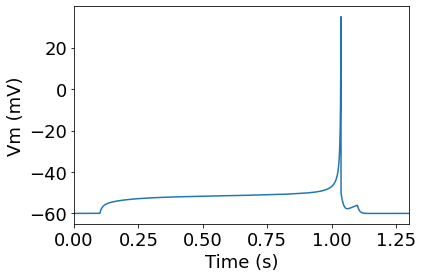

In [9]:
score_matrix['RheobaseTest']['V_rest=-60mV'].plot_vm() # Plot the rheobase current from the model with V_rest = -60 mV